In [266]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Vorstände - Einzeldaten

Tabelle mit konkreten Bezügen für Personen, die unterteilt sind in Grundgehalt und erfolgsabhängige Bezüge. Größtenteils für NRW. Dazu ausgewählte Sparkassen in Hessen und für andere Bundesländer

In [267]:
df = pd.read_csv('./data/jahresabschluss_vorstand.csv')
df_kerndaten = pd.read_csv('./data/jahresabschluss_kerndaten.csv')

## Wie hoch ist der Anteil erfolgsabhängiger Gehälter am Gesamtgehalt? 

Die erfolgsabhängigen Bezüge für einen Vorstand werden immer erst im nächsten Jahr ausgewiesen, daher gelten die Werte von `erfolgsabhaengige_bezuege` von 2014 für den Zeitraum von 2013, in dem diejenige Person im Vorstand war.

In [268]:
# convert to date
df.since = pd.to_datetime(df.since)
df.until = pd.to_datetime(df.until)

# set year
df['year'] = df.until.map(lambda x: x.year)

# get previous "gesamtverguetung"
def get_salary(row):
    if row.year == 2014:
        lookup = df[(df.name == row['name']) & (df.year == 2013)]
        if len(lookup) == 1:
            return lookup.iloc[0].gesamtverguetung

df['gesamtverguetung_2013'] = df.apply(get_salary, axis=1)

# calculate quota
df['bezuege_quote_zu_2013'] = df.erfolgsabhaengige_bezuege / df.gesamtverguetung_2013

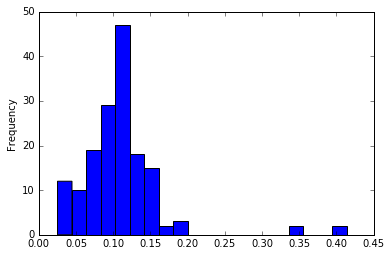

In [270]:
df_bezuege_quota = df[(df.bezuege_quote_zu_2013 > 0) & (df.year == 2014)]
df_bezuege_quota.bezuege_quote_zu_2013.plot.hist(bins=20)

## Gibt es Anteile, die auffällig hoch sind?

Empfehlung: nicht mehr als 15 %

### Wie viele sind über der Verbandsempfehlung?

In [223]:
len(df_bezuege_quota[df_bezuege_quota.bezuege_quote_zu_2013 > 0.15].index)

19

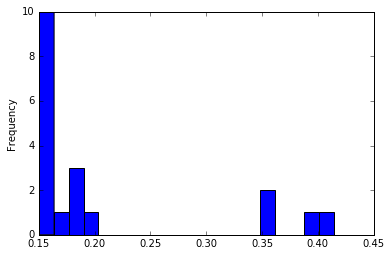

In [224]:
df_bezuege_quota[df_bezuege_quota.bezuege_quote_zu_2013 > 0.15].bezuege_quote_zu_2013.plot.hist(bins=20)

## Welche Sparkassen vergeben eine hohe Quote?

Bzw. woran liegt das oder wie korrelieren andere Größen damit?

In [272]:
# groupy by sparkasse
df_bezuege_group = df_bezuege_quota[
    ['sparkasse', 'gesamtverguetung_2013', 'erfolgsabhaengige_bezuege']
].groupby('sparkasse', as_index=False).sum()

# merge with sparkassen kerndaten data
df_spk = pd.merge(df_bezuege_group, df_kerndaten, on='sparkasse')

# calculate overall quota
df_spk['bezuege_quote_zu_2013'] = df_spk.erfolgsabhaengige_bezuege / df_spk.gesamtverguetung_2013

# overview top 10
df_spk.sort_values('bezuege_quote_zu_2013', ascending=False)[
    ['sparkasse', 'gesamtverguetung_2013', 'erfolgsabhaengige_bezuege', 'bezuege_quote_zu_2013']
][:10]

,sparkasse,gesamtverguetung_2013,erfolgsabhaengige_bezuege,bezuege_quote_zu_2013
0,Frankfurter Sparkasse,2373000.0,900000.0,0.379267
28,Sparkasse KölnBonn,2234110.0,412600.0,0.184682
43,Stadt- und Kreissparkasse Darmstadt,1219000.0,195000.0,0.159967
22,Sparkasse Hanau,909000.0,142000.0,0.156216
12,Sparkasse Dieburg,709900.0,108900.0,0.153402
1,Kasseler Sparkasse,1187000.0,178000.0,0.149958
3,Kreissparkasse Groß-Gerau,1053000.0,154000.0,0.146249
17,Sparkasse Gießen,241000.0,35000.0,0.145228
58,Stadtsparkasse Schwalmstadt,278000.0,38000.0,0.136691
6,Kreissparkasse Limburg,410000.0,54000.0,0.131707


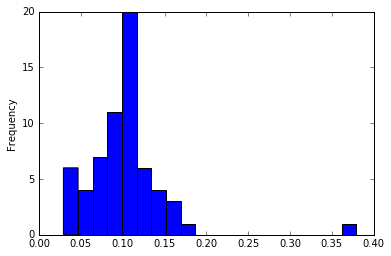

In [227]:
df_spk.bezuege_quote_zu_2013.plot.hist(bins=20)

### Bemessungsgrundlage

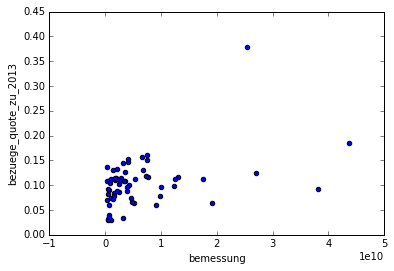

In [232]:
df_spk['bemessung'] = df_spk.bilanzsumme_2013 + df_spk.eigenkapital_2013*10
df_spk.plot.scatter('bemessung', 'bezuege_quote_zu_2013')

### Jahresüberschuss

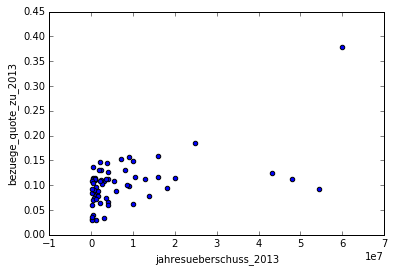

In [234]:
df_spk.plot.scatter('jahresueberschuss_2013', 'bezuege_quote_zu_2013')

### Zinsüberschuss

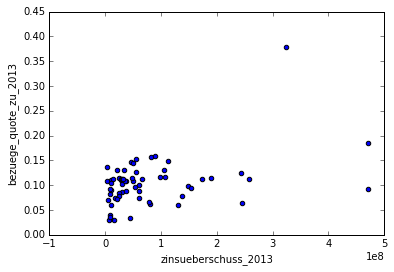

In [235]:
df_spk.plot.scatter('zinsueberschuss_2013', 'bezuege_quote_zu_2013')

## Wie unterscheidet sich diese Quote zwischen den Sparkassenverbänden?

In [278]:
df_asso = pd.merge(df_bezuege_group, 
                   df_kerndaten[['sparkasse', 'anzahl_vorstaende_2013', 'verband']],
                   on='sparkasse')

df_asso_group = df_asso.groupby('verband', as_index=False).sum()

# get data per board member
df_asso_group['verguetung_per_member'] = df_asso_group.gesamtverguetung_2013 / df_asso_group.anzahl_vorstaende_2013
df_asso_group['bezuege_per_member'] = df_asso_group.erfolgsabhaengige_bezuege / df_asso_group.anzahl_vorstaende_2013
df_asso_group['per_member_quota'] = df_asso_group.bezuege_per_member / df_asso_group.verguetung_per_member

df_asso_group

,verband,gesamtverguetung_2013,erfolgsabhaengige_bezuege,anzahl_vorstaende_2013,verguetung_per_member,bezuege_per_member,per_member_quota
0,RSGV,17147238.36,1901380.0,42.50,403464.432000,44738.352941,0.110885
1,SGVHT,12812900.00,2253900.0,43.90,291865.603645,51341.685649,0.175909
2,SVB,1779000.00,223319.0,5.30,335660.377358,42135.660377,0.125531
3,SVBW,247000.00,27000.0,3.00,82333.333333,9000.000000,0.109312
4,SVWL,24607300.00,2193900.0,78.81,312235.756884,27837.837838,0.089156


## Wie viele Gehälter haben wir, die nicht NRW sind? 

Hat zum Beispiel in Hessen fast jeder Sparkassen die Gehälter veröffentlicht und es hat bislang noch kein Medium erkannt, weil sie es nicht offiziell gemacht haben? Hintergrund: Der Pressesprecher vom hessischen Verband meinte zu mir, dass mittlerweile seine Sparkassen die konkreten Bezüge veröffentlichen, weil jeder durch die Gesamtbezüge den Durchschnitt ausrechnen könnte und dann würden sie lieber das richtige konkrete Gehalt veröffentliht sehen.

In [279]:
df_vorstand_asso = pd.merge(df, df_kerndaten, on='sparkasse')
df_vorstand_asso.verband.value_counts()

SVWL                        312
SGVHT                       194
RSGV                        176
SVN                         123
SVB                         122
OSV                         114
SVBW                        101
SVRP                         63
SVSH                         36
SVSaar                       20
HSGV                         13
Sparkassenverband Berlin     12
Name: verband, dtype: int64

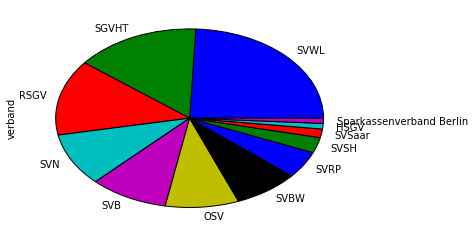

In [280]:
df_vorstand_asso.verband.value_counts().plot.pie()

In [281]:
df_vorstand_asso[df_vorstand_asso.verband != 'SVWL'].shape

(974, 65)